In [ ]:
#Project 1, Data Science Nanodegree: Write a data science blog post 

In [ ]:
#Questions related to business :
#Data Exploration on San Francisco Airbnb rentals

#1.Which amenities, factors, characteristics contribute most of the earnings to
#the Airbnb rentals in San Francisco?
#2.What factors affect the price of an Airbnb rental in San Francisco?
#3.What are the modeling price of the these Airbnb rentals ?

In [5]:
#importing libraries for analysis, exploaration and model

import gzip
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from collections import Counter
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, cohen_kappa_score, log_loss, auc
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, accuracy_score, classification_report, precision_score, recall_score
from scipy.stats import ks_2samp


In [8]:
#loading the Airbnb datasets 
listings = pd.read_csv('listings.csv')
listing_summary =pd.read_csv('listings_detailed.csv')

with open('calendar.csv.gz', 'rb') as fd:
    gzip_fd = gzip.GzipFile(fileobj=fd)
    calendar = pd.read_csv(gzip_fd)
    
with open('reviews2.csv.gz', 'rb') as fd:
    gzip_fd = gzip.GzipFile(fileobj=fd)
    reviews = pd.read_csv(gzip_fd)

reviews_summary = pd.read_csv('reviews.csv')

In [ ]:
#Understanding, exploring and cleaning data 

In [10]:
#These are the variables we got in the listings datset 
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [11]:
#These are the variables in the listing summary dataset 
listing_summary.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [12]:
#these are the variables in the calendar dataset 
calendar.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [13]:
#These are the variables in the reviews dataset 
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [ ]:
#Let's analyze the listings dataset 

In [14]:
#checking the proportions 
listings.shape

(7087, 74)

In [15]:
#checking the data type of each column variable 
pd.set_option('display.max_rows', 75) 
table_dtypes = pd.DataFrame(listings.dtypes)
table_dtypes.rename(columns = {0: 'dtypes'}, inplace = True)
table_dtypes

,dtypes
id,int64
listing_url,object
scrape_id,int64
last_scraped,object
name,object
description,object
neighborhood_overview,object
picture_url,object
host_id,int64
host_url,object


In [16]:
#Examining how many missing values we got by column
pd.set_option('display.max_rows', 75) 
table_nulls = pd.DataFrame(listings.isnull().sum())
table_nulls.rename(columns = {0: 'Null_values'}, inplace = True)
table_nulls

,Null_values
id,0
listing_url,0
scrape_id,0
last_scraped,0
name,0
description,65
neighborhood_overview,1955
picture_url,0
host_id,0
host_url,0


In [17]:
#drop unnecesary variables like id and host name 
listings.drop(['id','host_name'], axis=1, inplace=True)

In [18]:
#Let's analyze the price variable 

In [19]:
#set this for further plots
sns.set()
sns.set_style('whitegrid')

In [20]:
#cleanning price var 
listings['price'] = listings['price'].str[1:]
listings['price'] = listings['price'].str[:-3]
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].astype(int)

In [21]:
#Stats of price variable 
listings.price.describe()

count     7087.000000
mean       248.599125
std        817.421870
min         10.000000
25%         85.000000
50%        133.000000
75%        215.000000
max      25000.000000
Name: price, dtype: float64

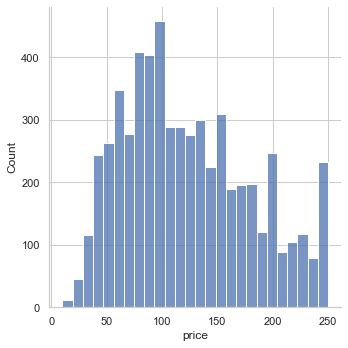

In [22]:
#price distribution without outliers
price_without_outliers= listings[listings['price'] <= 250]
graph_1 = sns.displot(price_without_outliers, x="price")
graph_1

In [23]:
#Stats of number of reviews 
listings.number_of_reviews.describe()

count    7087.000000
mean       43.570340
std        82.587244
min         0.000000
25%         1.000000
50%         7.000000
75%        46.000000
max       821.000000
Name: number_of_reviews, dtype: float64

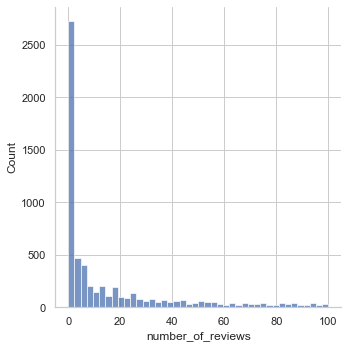

In [24]:
#distribution without outliers
reviews_without_outliers= listings[listings['number_of_reviews'] <= 100]
graph_2 = sns.displot(reviews_without_outliers, x="number_of_reviews")
graph_2

In [25]:
#Counting neighbourhoods
table_nbds = pd.DataFrame(listings.neighbourhood.value_counts())
table_nbds.rename(columns = {'neighbourhood': 'Count'}, inplace = True)
table_nbds

,Count
"San Francisco, California, United States",5119
"Daly City, California, United States",8
"San Franscisco, California, United States",1
"Noe Valley - San Francisco, California, United States",1
"San Francisco , California, United States",1
"San Francisco , Ca, United States",1
"San Jose, California, United States",1


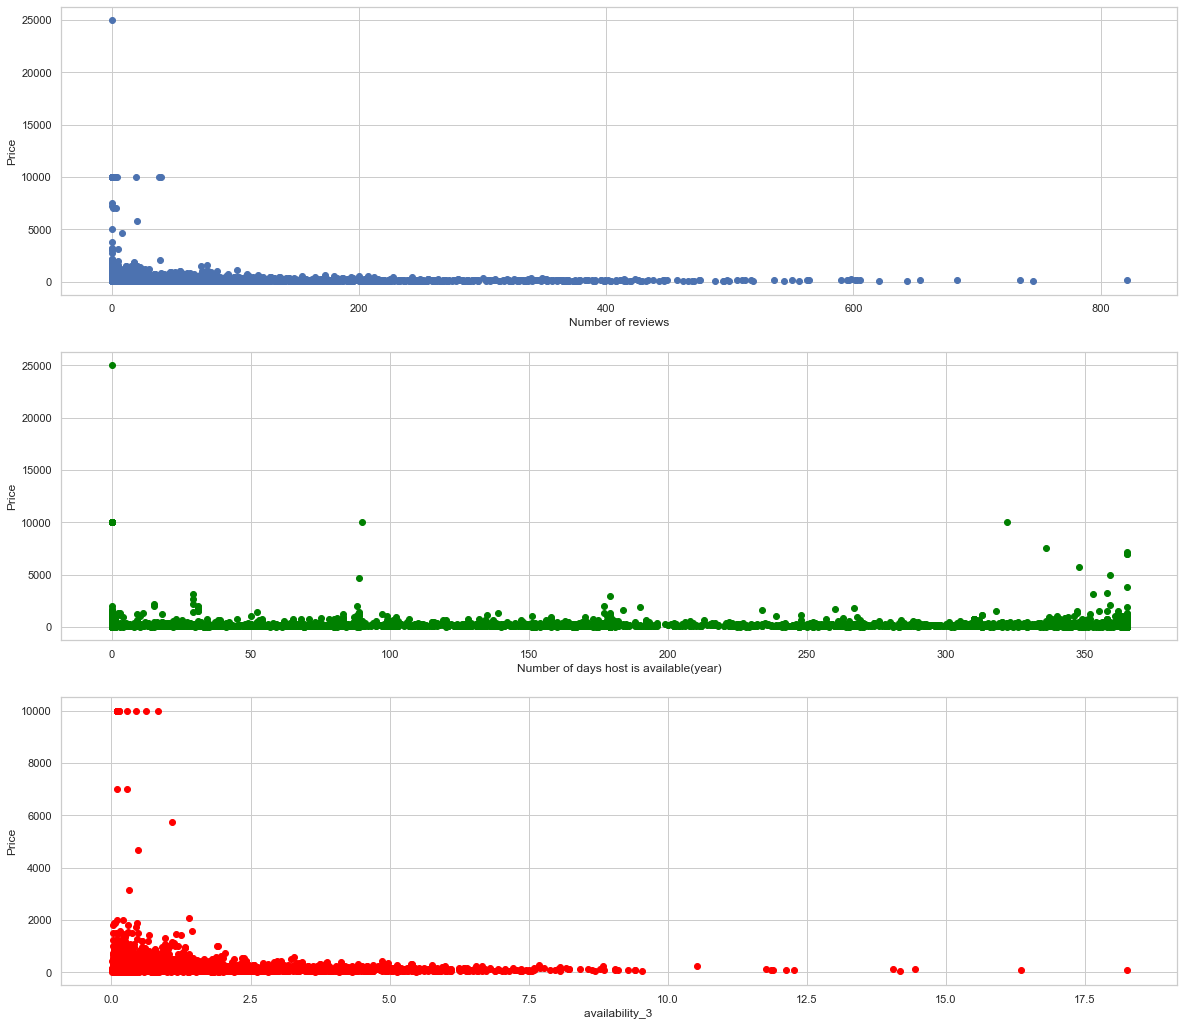

In [26]:
#correlations between prices, number of reviews, reviews per month, and number of days host is available 
fig, axs = plt.subplots(3, figsize=(20,18))

axs[0].scatter(listings.number_of_reviews, listings.price)
axs[0].set(xlabel = 'Number of reviews', ylabel = 'Price')

axs[1].scatter(listings.availability_365, listings.price, c='green')
axs[1].set(xlabel = 'Number of days host is available(year)', ylabel = 'Price')

axs[2].scatter(listings.reviews_per_month, listings.price, c='red')
axs[2].set(xlabel = 'availability_3 ', ylabel = 'Price')


plt.show()

In [27]:
#Counting property types
table_propt = pd.DataFrame(listings.property_type.value_counts())
table_propt.rename(columns = {'property_type': 'Count'}, inplace = True)
table_propt

,Count
Entire apartment,2045
Private room in house,966
Entire house,769
Private room in apartment,666
Entire condominium,635
Entire guest suite,454
Room in boutique hotel,335
Private room in condominium,192
Room in hotel,177
Entire serviced apartment,161


In [28]:
#top 10 reviewed prices and their price average 
top_reviewed= listings.nlargest(10,'number_of_reviews')

avrg_prc = top_reviewed.price.mean()
print('Average price per night in San Francisco 2020: {}'.format(avrg_prc))

Average price per night in San Francisco 2020: 124.5


[Text(0, 0, '4430421'),
 Text(1, 0, '17042045'),
 Text(2, 0, '48005494'),
 Text(3, 0, '70722023'),
 Text(4, 0, '107434423'),
 Text(5, 0, '117141107'),
 Text(6, 0, '173206762'),
 Text(7, 0, '262211596'),
 Text(8, 0, '267895362'),
 Text(9, 0, '285808053')]

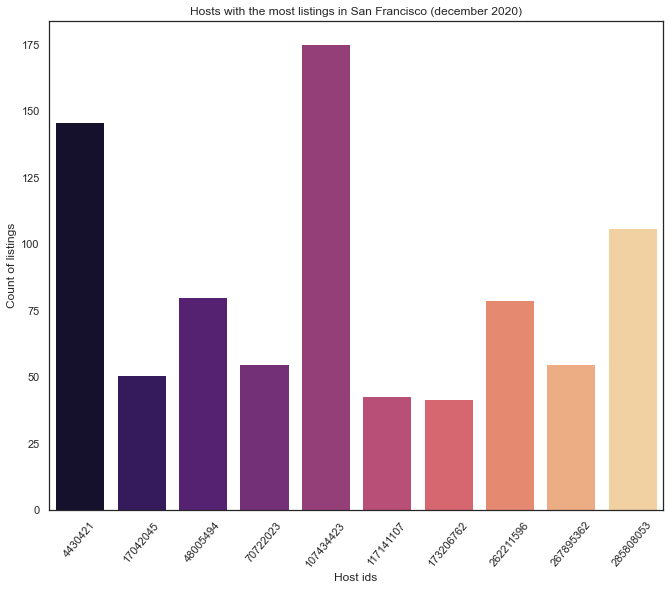

In [29]:
#Analizing the top 10 hosts with the most listings on Airbnb platform in San Francisco
super_hosts=listings.host_id.value_counts().head(10)
super_hosts

#create a dataframe of super hosts 
super_host_table=pd.DataFrame(super_hosts)
super_host_table.reset_index(inplace=True)
super_host_table.rename(columns={'index':'host_id', 'host_id':'count'}, inplace=True)

#Graph with the most listings on Airbnb platform 

sns.set(rc={'figure.figsize':(11,9)})
sns.set_style('white')

graph_4=sns.barplot(x="host_id", y="count", data=super_host_table,
                 palette='magma')
graph_4.set_title('Hosts with the most listings in San Francisco (december 2020)')
graph_4.set_ylabel('Count of listings')
graph_4.set_xlabel('Host ids')
graph_4.set_xticklabels(graph_4.get_xticklabels(), rotation=50)

[Text(0, 0, 'in'),
 Text(1, 0, 'private'),
 Text(2, 0, 'room'),
 Text(3, 0, 'with'),
 Text(4, 0, 'the'),
 Text(5, 0, 'bedroom'),
 Text(6, 0, 'studio'),
 Text(7, 0, '-'),
 Text(8, 0, '&'),
 Text(9, 0, 'sf'),
 Text(10, 0, 'home'),
 Text(11, 0, 'mission'),
 Text(12, 0, 'near'),
 Text(13, 0, 'of'),
 Text(14, 0, 'w/'),
 Text(15, 0, 'victorian'),
 Text(16, 0, 'hill'),
 Text(17, 0, 'suite'),
 Text(18, 0, 'san'),
 Text(19, 0, 'and'),
 Text(20, 0, 'apartment'),
 Text(21, 0, 'modern'),
 Text(22, 0, '2'),
 Text(23, 0, 'garden'),
 Text(24, 0, 'to'),
 Text(25, 0, 'sunny'),
 Text(26, 0, 'hotel'),
 Text(27, 0, 'spacious'),
 Text(28, 0, 'park'),
 Text(29, 0, 'union'),
 Text(30, 0, 'francisco'),
 Text(31, 0, '1'),
 Text(32, 0, 'square'),
 Text(33, 0, 'valley'),
 Text(34, 0, 'cozy'),
 Text(35, 0, 'house'),
 Text(36, 0, 'by'),
 Text(37, 0, 'bath'),
 Text(38, 0, 'a'),
 Text(39, 0, 'view'),
 Text(40, 0, 'views'),
 Text(41, 0, 'flat'),
 Text(42, 0, 'heart'),
 Text(43, 0, 'condo'),
 Text(44, 0, 'beautiful'),

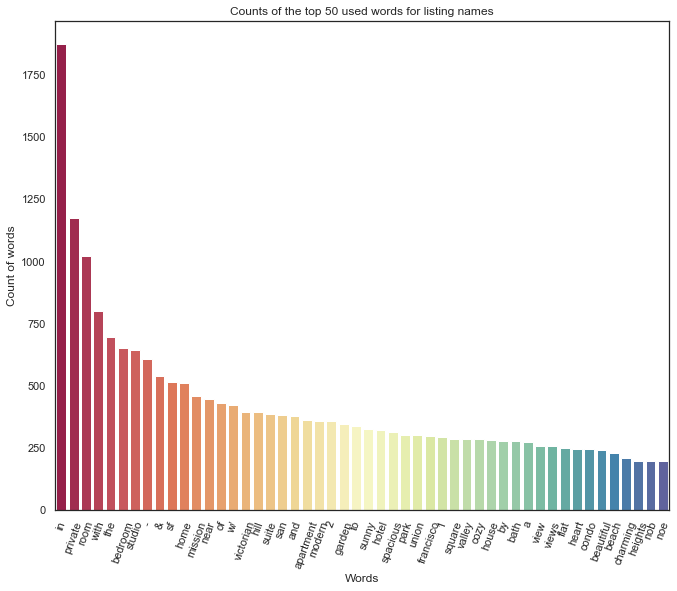

In [30]:
#analizing the words in the name variable 

names_listings=[]
for name in listings.name:
    names_listings.append(name) 
    
def splitting(name):
    splt=str(name).split()
    return splt 

names_count=[]

for i in names_listings:
    for j in splitting(i):
        words = j.lower()
        names_count.append(words)
        
#See the 50 most frequent words 
top_50_words=Counter(names_count).most_common()
top_50_words=top_50_words[0:50]

words_table=pd.DataFrame(top_50_words)
words_table.rename(columns={0:'words', 1:'count'}, inplace=True)

#plot 
graph_5=sns.barplot(x='words', y='count', data=words_table, palette = "Spectral")
graph_5.set_title('Counts of the top 50 used words for listing names')
graph_5.set_ylabel('Count of words')
graph_5.set_xlabel('Words')
graph_5.set_xticklabels(graph_5.get_xticklabels(), rotation=70)

In [ ]:
#Task 1

In [33]:
#creating var revenue per availble room 
listings["rev_per_avail_room"] = (listings['price'] * (30 - listings['availability_30']))

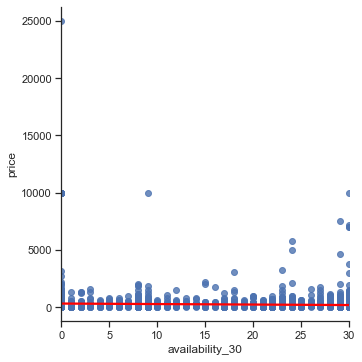

In [32]:
#realtionship between price and occupacy rate 

sns.set(style="ticks")
sns.lmplot(x="availability_30", y="price", data=listings, line_kws={'color': 'red'})
plt.show()

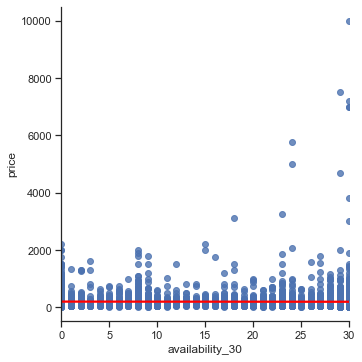

In [34]:
#realtionship between price and occupacy rate (whitout outliers)
reven_PAvailRroom_without_outliers = listings[np.abs(listings.rev_per_avail_room-listings.rev_per_avail_room.mean())<=(3*listings.rev_per_avail_room.std())]
sns.lmplot(x="availability_30", y="price", data=reven_PAvailRroom_without_outliers, line_kws={'color': 'red'})
plt.show()

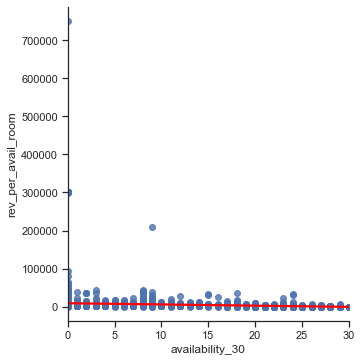

In [35]:
#relationship between revenue per available room and availability 
sns.lmplot(x="availability_30", y="rev_per_avail_room", data=listings, line_kws={'color': 'red'})
plt.show()

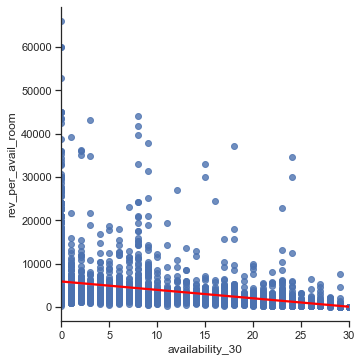

In [36]:
#relationship between revenue per available room and availability  (whitout outliers)
sns.lmplot(x="availability_30", y="rev_per_avail_room", data= reven_PAvailRroom_without_outliers,  line_kws={'color': 'red'})
plt.show()

In [37]:
#The average and the median monthly revenue
print("Average Monthly Revenue:", listings["rev_per_avail_room"].mean())
print("Median Monthly Revenue:", listings["rev_per_avail_room"].median())

Average Monthly Revenue: 4870.320586990264
Median Monthly Revenue: 2016.0


In [48]:
#Tranform in a binary feature the amenity variables to analyze the importance of the 
#contribution in the rental earnings of San Francisco

amenities_list = ['Kitchen', 'Shampoo', 'Dryer Essentials', 'Private entrance', 'Garden or backyard', 
                  'Stove', 'Cable TV', 'Coffee maker','Washer', 'Hair dryer', 'Iron', 'Wifi', 
        'Dishes and silverware', 'Room darkening shades', 'Keypad', 'Microwave Oven', 'Heating', 'Refrigerator', 'Essentials',
       'Play travel crib', 'Cooking basics', 'Hangers', 'Free street parking',
       'Smoke alarm', 'First aid kit', 'Hot water', 'Dedicated workspace',
       'Fire extinguisher', 'Host bedroom door', 'Dishwasher', 'Bed linens', 'Extra pillows and blankets', 
       'Luggage drop off allowed', 'Indoor fireplace', 'Children books and toys',
       'Lockbox', 'High chair', 'Elevator', 'Patio or balcony', 'Free parking on premises'
       'Paid parking off premises', 'Babysitter recommendations', 'Baby safety gates',
       'BBQ grill', 'Long term stays',
       'Ethernet connection', 'Hot tub', 'Pocket wifi', 'Breakfast',
       'Body soap', 'Air conditioning', 'Full kitchen', 
       'Bedroom comforts', 'Bathroom essentials', 'Shower gel',
       'Private living room', 'Children dinnerware', 'Bathtub', 'Ceiling fan',
       'Mini fridge', 'In building', 'Portable fans', 'HDTV', 'Netflix', 'Amazon', 'Prime Video',
        'HBO Max', 'Chromecast', 'Single level home',
       'Pool', 'Building staff', 'Gym', 'Cleaning before checkout', 
       'Baking sheet','Conditioner unit', 'Stainless steel gas stove', 
       'Stainless steel oven',
       'Freezer', 'Game console','Sound system', 'Fireplace guards', 'Electric stove', 'Outlet',
       'covers', 'EV', 'charger', 'Bread', 'Rice', 'Changing table',
       'Barbecue utensils', 'Window guards', 'Kitchenette', 'Smart lock',
       'Table corner', 'Kitchen standard cable', 'HDTV with standard', 'Record player',
       'Sonos', 'Bluetooth sound', 'Pour over coffee' , 'Baby monitor',
       'Pantene conditioner', 'Nespresso machine',
       'Panasonic sound system with aux Patio',
       'Sound system with Bluetooth and aux', 'Trash compactor', 
       'Piano', 'Pets allowed', 'Self check', 'Laundromat nearby', 'Beach essentials', 
       '100 Mbps', '20 Mbps','600 Mbps','1000 Mbps','90 Mbps','500 Mbps','700 Mbps',
       '240 Mbps', 'double burner', 'Black Decker',
       'electric stove', 'Beachfront', 'Waterfront', 'Central heating', 
        'Free driveway parking ', 'Free residential garage', 'Paid parking garage', '1 space',
        'Cafe', 'stainless steel oven ', '2 spaces',
        'Suitable events', 'Cook top induction', 'Verona stainless steel oven', 'Undercounter half size fridge',
        'Dishwasher Dr Bronner','Bose sound system',
        'Samsung refrigerator', 'Portable heater', 'Kitchen premium cable', 
        'HDTV with premium', 'Taotronics sound system', 'EO Organics', 'EO body soap', 'EO conditioner'
        'Smoking allowed', 'Denon', 'Bosch', 'Jenn', 'Yamaha', 
        'Self check in', 'Shared fenced garden or backyard', 'Shared hot tub',
        'Lake access', 'Hot water kettle', 'Clothing storage',
        'Dining', 'Outdoor dining area', 'Cleaning products', 'Suave body soap',           
        'Bed linens Bergman ', 'Techwood', 'Countertop', 'Double Burner', 'Infrared', 'Ceramic', 'Cooktop',
        'Double Cooktop 1800W With Adjustable Temperature Control', 'Brushed', 'Easy to Clean',
        'Upgraded Version', 'Neutrogena body soap ', 
        'Frigidare gas stove', 'bose sound system', 'Toaster', 'Convection', 'Apple', 
        'Roku','Alba conditioner', 'Alba shampoo', 'Cuisinart', 
        'Sonos 3 speakers', 'Niles speakers', 'Paradigm speakers sound system with aux', 
        'Polk built in speakers with Airplay sound system',  'Sonos JBL in ceiling speakers', 
        'Harmon Kardon', 'Shea Logix', 'Clothing storage closet', 'Terrace', 'Walk in closet', 'Wine glasses',
        'Wine cooler', 'Whirlpool electric', 'Whirlpool oven', 'Technics receiver amp',
        'Summer s Eve', 'Cleansing', 'Costco', 'bar', 'Fire pit',
        'Outdoor furniture ', 'Vintage', 'Magic Chef',
        'medium size refrigerator', 'Thermidor refrigerator', 'Thermidor gas stove', 
        'Dual vanity', 'Stand alone rain', 'Stand alone steam shower', 'Media room', 
        'Espresso machine', 'Nest thermometer', 'Ironing board', 'Home theater',
        'Wet bar', 'Security cameras', 'AC valet',
        'freezer', 'Dove sensitive skin body soap', 'Radiant heating', 'Induction',
        'Dacor refrigeratos', 'Aesop body soap', 'Aesop conditioner', 'Aesop shampoo', 'Aveno body',
        'Lounge', 'Gas', 'Desk', 'Natural gas', 'barbeque',
        'Harmon Kardon NXT and Yamaha in wall theater system sound system', 'wall', 
        'Sony sound system', 'Boze','Indoor fireplace'
        'Courtyard', 'Massage table','Carbon monoxide alarm', 
        'Driveway parking', 'Wood burning fireplace ', 'Jetted tub',
        'Smart home technology', 'In top shelf in closet', 'organic body soap', 'Greenwich Bay',
        'Exfoliating Body', 'Tea body soap Enriched with Shea Butter',
        'Moist conditioner Blended with Loofah and Apricot Seed', 
        'Lemongrass', ' Aussie Deep Conditioner',
        'Love Beauty and Planet eco conscious brand', 
        'Parasound', 'audiophile equipment sound system with Bluetooth and aux'
        'HomePods', 'Maytag refrigerator', 'Heating skillet stove', 'Ace Hotel',
        'Fisher Paykel', 'Bertazoni stainless steel oven', 'JBL',
        'Electrolux refrigerator', 'Thermador stainless steel gas stove', 
        'Google', 'Marshall Bluetooth sound system', 'Luggage dropoff allowed', 'Keefe and Merritt']
for amenity in amenities_list:
    listings[amenity] = listings.amenities.str.contains(amenity)

In [41]:
#create a binary target variable for the classification model
Average_revPerAvailr = listings["rev_per_avail_room"].mean()
listings["winner"] = [1 if x >= Average_revPerAvailr else 0 for x in listings["rev_per_avail_room"]]

In [50]:
amenities_list.append('winner')

In [54]:
#We can observe how by each amenity it contributes to the success of rooms rentals, by
#grouping by amenity type and the mean of the rooms with high revenue. 
#add winner to the list
amenities_list.append('winner')
for contribution in amenities_list:
    print(listings.groupby(contribution)['winner'].mean())

Kitchen
False    0.269055
True     0.209654
Name: winner, dtype: float64
Shampoo
False    0.156980
True     0.242709
Name: winner, dtype: float64
Dryer Essentials
False    0.22252
Name: winner, dtype: float64
Private entrance
False    0.181216
True     0.278498
Name: winner, dtype: float64
Garden or backyard
False    0.205659
True     0.271280
Name: winner, dtype: float64
Stove
False    0.219684
True     0.226761
Name: winner, dtype: float64
Cable TV
False    0.181629
True     0.308399
Name: winner, dtype: float64
Coffee maker
False    0.189056
True     0.247831
Name: winner, dtype: float64
Washer
False    0.192308
True     0.234415
Name: winner, dtype: float64
Hair dryer
False    0.120428
True     0.241703
Name: winner, dtype: float64
Iron
False    0.119301
True     0.246058
Name: winner, dtype: float64
Wifi
False    0.044872
True     0.226519
Name: winner, dtype: float64
Dishes and silverware
False    0.22370
True     0.22153
Name: winner, dtype: float64
Room darkening shades
False  

Paradigm speakers sound system with aux
False    0.222552
True     0.000000
Name: winner, dtype: float64
Polk built in speakers with Airplay sound system
False    0.22252
Name: winner, dtype: float64
Sonos JBL in ceiling speakers
False    0.22252
Name: winner, dtype: float64
Harmon Kardon
False    0.222442
True     0.500000
Name: winner, dtype: float64
Shea Logix
False    0.222442
True     0.500000
Name: winner, dtype: float64
Clothing storage closet
False    0.22252
Name: winner, dtype: float64
Terrace
False    0.222254
True     0.600000
Name: winner, dtype: float64
Walk in closet
False    0.222003
True     0.833333
Name: winner, dtype: float64
Wine glasses
False    0.222583
True     0.000000
Name: winner, dtype: float64
Wine cooler
False    0.222442
True     0.500000
Name: winner, dtype: float64
Whirlpool electric
False    0.222552
True     0.000000
Name: winner, dtype: float64
Whirlpool oven
False    0.222552
True     0.000000
Name: winner, dtype: float64
Technics receiver amp
False

In [73]:
#Create a new base with just amennities and features variables for modeling

#filter by index columns 
features_ =listings.iloc[: , [30,34,58,71]].join(listings.iloc[:,73:339])

In [79]:
#table of null values 
pd.set_option('display.max_rows', 1000)
table_ofnulls = pd.DataFrame(features_.isnull().sum())
table_ofnulls.rename(columns= {0:'Counts'}, inplace = True)
table_ofnulls

,Counts
room_type,0
bedrooms,882
review_scores_rating,1745
reviews_per_month,1703
Kitchen,0
Shampoo,0
Dryer Essentials,0
Private entrance,0
Garden or backyard,0
Stove,0


In [75]:
#we apply dummy fucntion to this object variable: room type 
features_ = pd.get_dummies(features_, columns=['room_type', ])

In [76]:
#Applying ordinal econder for categorical variables  
enc = OrdinalEncoder()
enc.fit(features_.iloc[:,3:268])
features_.iloc[:,3:268] = enc.transform(features_.iloc[:,3:268])

In [66]:
#correlations with the var winner 
table_corr = pd.DataFrame(features_[features_.columns[:]].corr()['winner'])
table_corr.rename(columns= {'winner': 'Correlation'}, inplace = True)
table_corr

,Correlation
bedrooms,0.344171
reviews_per_month,-0.162267
review_scores_rating,0.106203
Kitchen,-0.058828
Shampoo,0.087455
Dryer Essentials,NaN
Private entrance,0.115604
Garden or backyard,0.068936
Stove,0.008337
Cable TV,0.142472


In [78]:
#Modeling 

#Split into Train and Test
X= features_.drop("winner",axis=1)
y= features_[['winner']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [79]:
#fit 
xgbm = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
grow_policy='depthwise', n_estimators= 50, random_state= 42)
xgbm.fit(X_train, y_train)
#pred, confusion matrix, class report 
predictions_xgb =xgbm.predict(X_test)
xgb_probs = xgbm.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions_xgb))

print("Classification Report")
print(classification_report(y_test, predictions_xgb))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Confusion Matrix:
[[1023   63]
 [ 159  173]]
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1086
           1       0.73      0.52      0.61       332

    accuracy                           0.84      1418
   macro avg       0.80      0.73      0.76      1418
weighted avg       0.83      0.84      0.83      1418



In [98]:
#Scores
TP= 173
FP= 63
FN= 159
TN= 1023
accuracy_s = (TP + TN)/ (TP + FN + TN + FP)
recall_score =  TP / (FN + TP)
precision_score= TP / (FP + TP)
f1_score = 2* precision_score * recall_score/ (precision_score + recall_score)
print('Accuracy score: ', accuracy_s)
print('Recall score: ', recall_score)
print('Precision score: ', precision_score)
print('f1_score: ', f1_score)

Accuracy score:  0.843441466854725
Recall score:  0.5210843373493976
Precision score:  0.7330508474576272
f1_score:  0.6091549295774649


In [91]:
y_test['winner'].valuespredictions_xgb

array([1, 0, 0, ..., 0, 1, 0])

Train/Test results :
XGBClassifier accuracy : 0.843
XGBClassifier log_loss : 0.369
XGBClassifier auc : 0.867


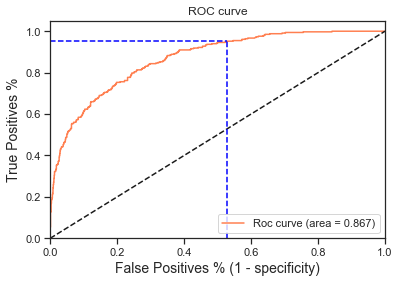

In [102]:
[fpr_xgb, tpr_xgb, thr_xgb] = roc_curve(y_test, xgb_probs)
print('Train/Test results :')
print(xgbm.__class__.__name__+" accuracy : %2.3f" % accuracy_score(y_test, predictions_xgb))
print(xgbm.__class__.__name__+" log_loss : %2.3f" % log_loss(y_test,xgb_probs))
print(xgbm.__class__.__name__+" auc : %2.3f" % auc(fpr_xgb, tpr_xgb))

idx_xgb = np.min(np.where(tpr_xgb > 0.95))

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='coral', label='Roc curve (area = %0.3f)' % auc(fpr_xgb, tpr_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr_xgb[idx_xgb]], [tpr_xgb[idx_xgb],tpr_xgb[idx_xgb]], 'k--', color='blue')
plt.plot([fpr_xgb[idx_xgb],fpr_xgb[idx_xgb]], [0,tpr_xgb[idx_xgb]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives % (1 - specificity)', fontsize=14)
plt.ylabel('True Positives %', fontsize=14)
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [95]:
#Some stats

#GINI
roc_auc =0.867
GINI = (2 * roc_auc) - 1
print("Gini:", GINI,"\n")

#kappa 
print("Kappa:", cohen_kappa_score(y_test,predictions_xgb), "\n")

Gini: 0.734 

Kappa: 0.5147428782833887 



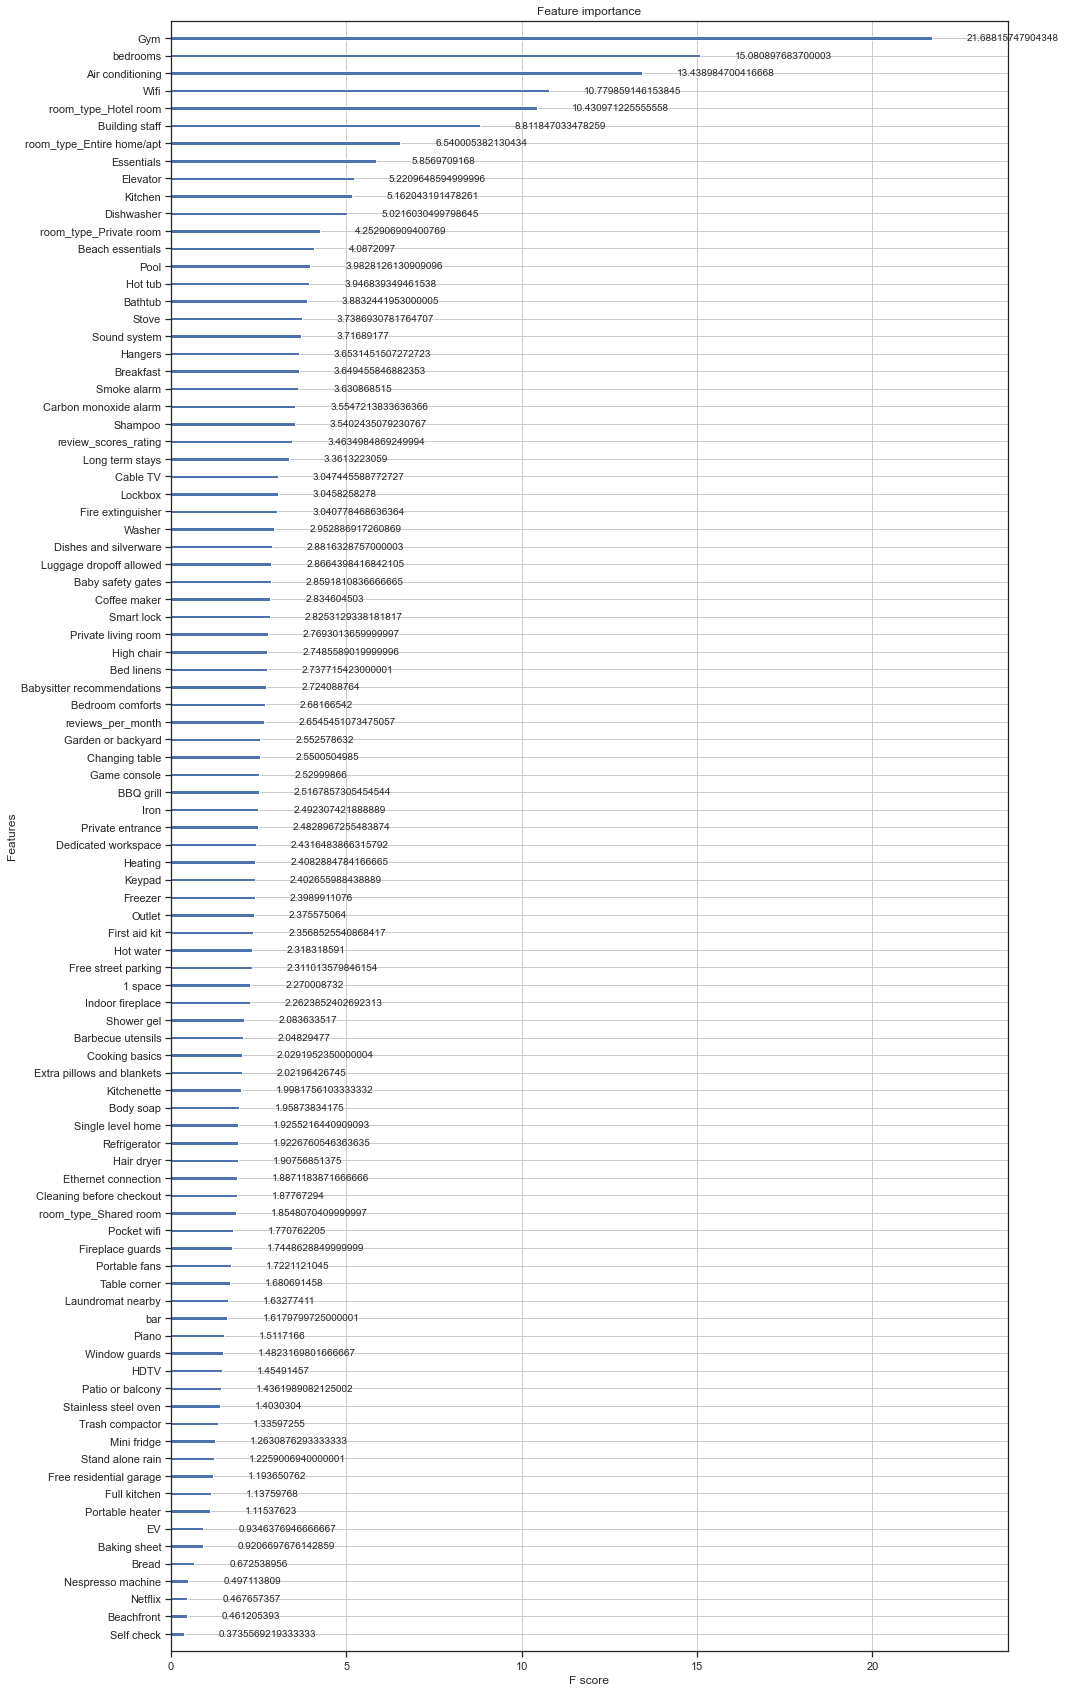

In [103]:
#feature importance 
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15,30))
plot_importance(xgbm, ax = ax, importance_type="gain")
#plt.rc('ytick',labelsize=0)
plt.show()

In [ ]:
#part 2

In [104]:
listings.price.describe()

count     7087.000000
mean       248.599125
std        817.421870
min         10.000000
25%         85.000000
50%        133.000000
75%        215.000000
max      25000.000000
Name: price, dtype: float64

In [105]:
#Drop outliers for getting better insights
prices = listings[listings['price'] <= 500]

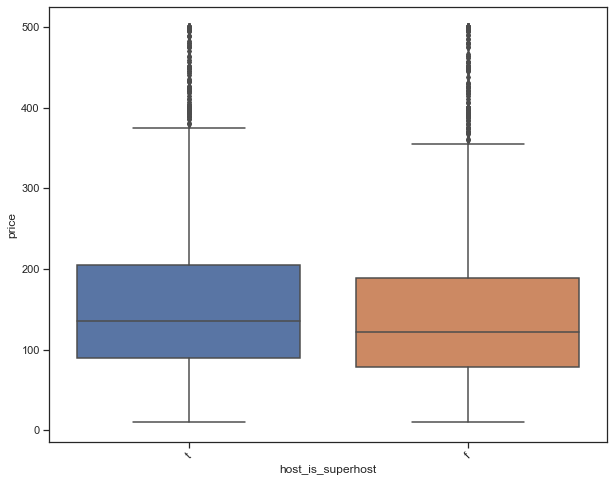

In [106]:
#boxplot

plt.figure(figsize=(10,8))
sns.boxplot(x='host_is_superhost',y='price',data= prices)
#graph_3=plt.gca()
#graph_3.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.xticks(rotation=45)
plt.show()

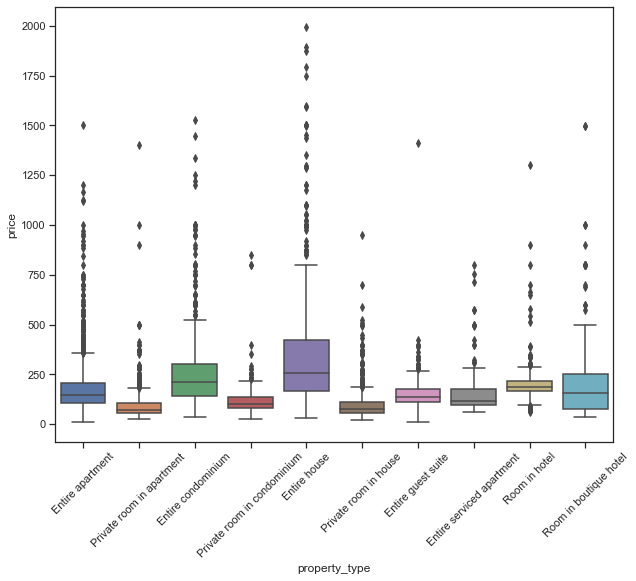

In [107]:
#Relationship between price and the top 10 property types

properties_ = ['Entire apartment', 'Private room in house', 'Entire house',
       'Private room in apartment', 'Entire condominium',
       'Entire guest suite', 'Room in boutique hotel',
       'Private room in condominium', 'Room in hotel',
       'Entire serviced apartment']
properties_ = listings.property_type.isin(properties_ )
properties_ =listings[properties_]
properties_ = properties_.reset_index(drop=True)
properties_ = properties_[properties_['price'] < 2000]
plt.figure(figsize=(10,8))
sns.boxplot(x='property_type',y='price',data= properties_)
#graph_3=plt.gca()
#graph_3.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.xticks(rotation=45)
plt.show()

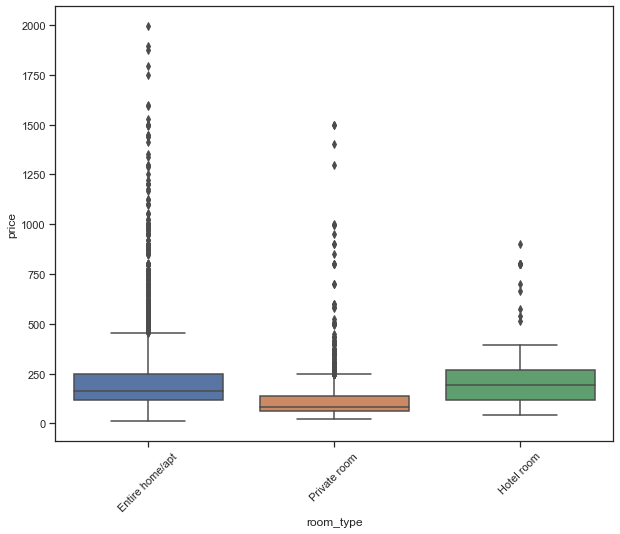

In [108]:
#Boxplot of room type
plt.figure(figsize=(10,8))
sns.boxplot(x='room_type',y='price',data= properties_)
plt.xticks(rotation=45)
plt.show()

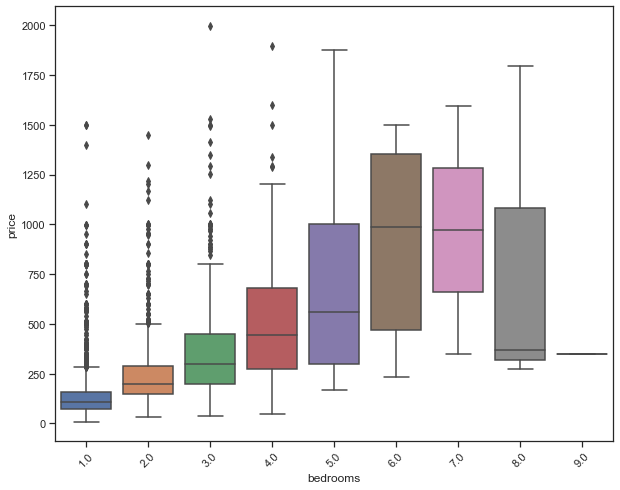

In [114]:
#box plot of bedrooms 
#properties_ = properties_[properties_['bedrooms'] != 1.4925060435132957]

plt.figure(figsize=(10,8))
sns.boxplot(x='bedrooms',y='price',data= properties_)
plt.xticks(rotation=45)
plt.show()

In [117]:
#corr with just numerical values 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_vars = listings.select_dtypes(include=numerics)

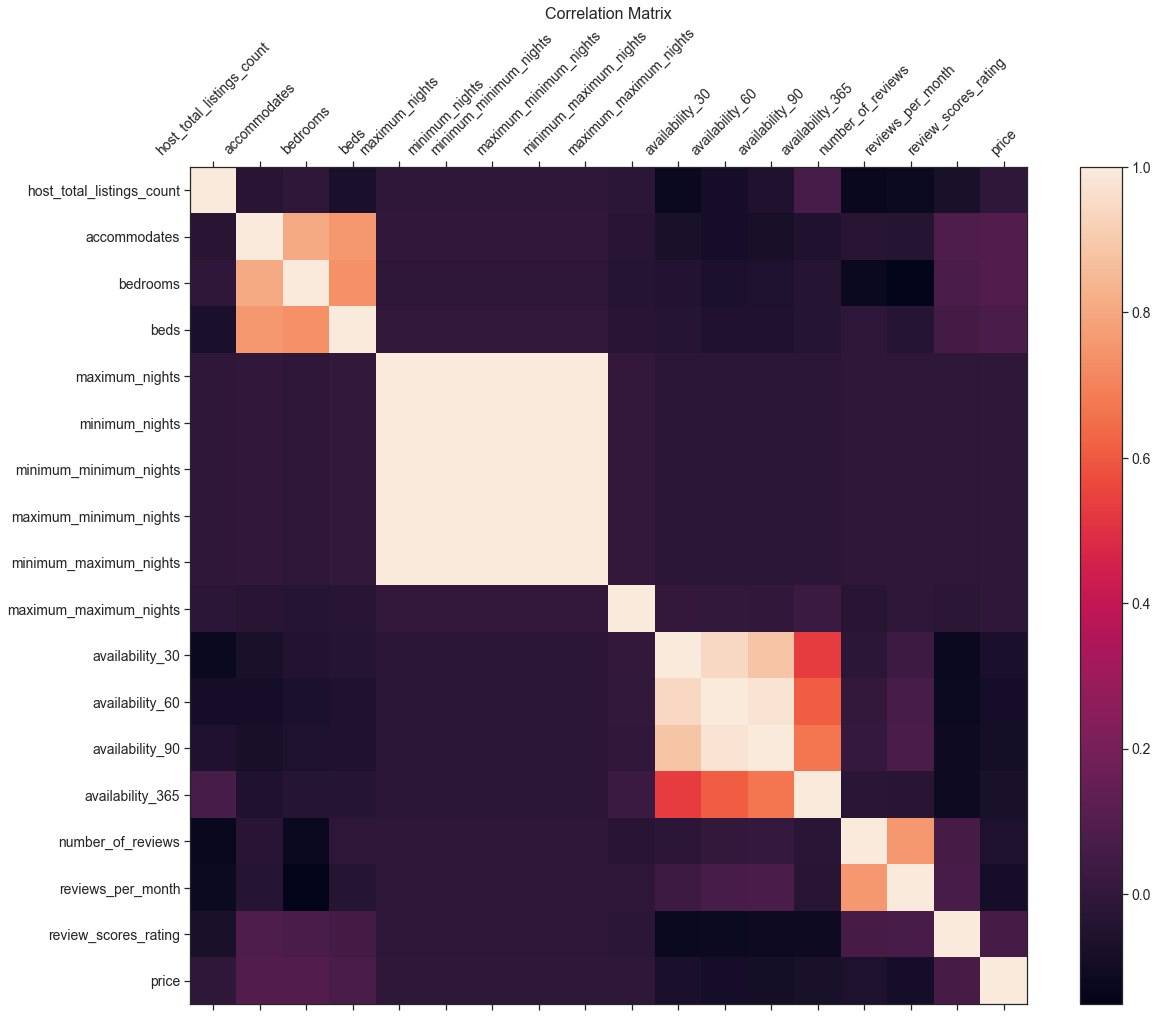

In [118]:
#Correlation plot 
f = plt.figure(figsize=(19, 15))
plt.matshow(numeric_vars.corr(), fignum=f.number)
plt.xticks(range(numeric_vars.shape[1]), numeric_vars.columns, fontsize=14, rotation=45)
plt.yticks(range(numeric_vars.shape[1]), numeric_vars.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

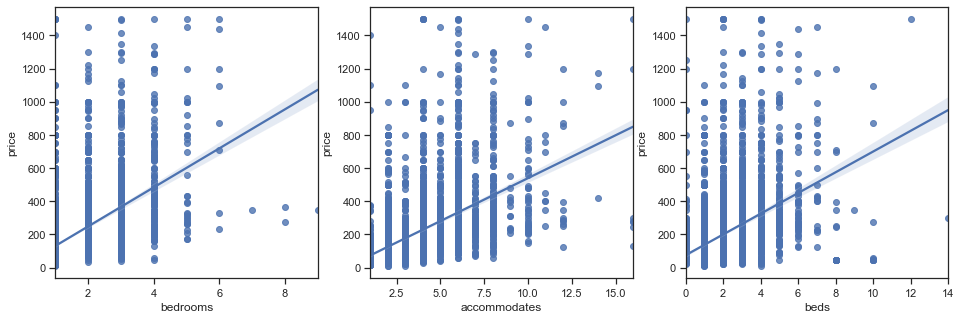

In [119]:
# Correlation Plot
fig, axs = plt.subplots(ncols=3, figsize=(16,5))
numeric_vars_ =numeric_vars[numeric_vars['price'] <= 1500]
sns.regplot(x='bedrooms', y='price', data=numeric_vars_, ax=axs[0])
sns.regplot(x='accommodates', y='price', data=numeric_vars_, ax=axs[1])
sns.regplot(x='beds',y='price', data=numeric_vars_, ax=axs[2])

plt.show()

In [ ]:
#part 3

In [120]:
listings.shape

(7087, 339)

In [102]:
#create a factors dataset for modeling 

#filter index columns
factors =listings.iloc[: , [15,30,34,37,38,39,40,41,42,44,48,49,50,51,53,58,71]].join(listings.iloc[:,73:338])

In [103]:
#applying ordinal encoder to categorical values 
enc = OrdinalEncoder()
enc.fit(factors.iloc[:,17:282])
factors.iloc[:,17:282] = enc.transform(factors.iloc[:,17:282])

In [104]:
#we apply dummy fucntion to this object variable: room type 
factors = pd.get_dummies(factors, columns=['room_type','host_is_superhost'])

In [ ]:
#Applying a XGBoost Algorithm for prediction

In [141]:
#Splitting the dataset 
X= factors.drop("price",axis=1)
y= factors[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [142]:
X_train= X_train.loc[:,~X_train.columns.duplicated()]
X_test= X_test.loc[:,~X_test.columns.duplicated()]

In [143]:
#Fit 
xgb2 = XGBClassifier(objective = 'reg:squarederror')
xgb2.fit(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:19:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
#predictions
pred_train= xgb2.predict(X_train)
print('\nTarget on Train',pred_train)

pred_test= xgb2.predict(X_test)

print('\nTarget on Test',pred_test)


Target on Train [ 90 179 131 ... 140 232 250]

Target on Test [150 150  60 ... 125 174 145]


In [145]:
#R2 and RMSE scores 
print('Train r2 score : ', r2_score(pred_train, y_train))
print('Test r2 score : ', r2_score(y_test, pred_test ))

train_mse1 = mean_squared_error(pred_train, y_train)
test_mse1 = mean_squared_error(pred_test, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)

print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.692008868549764
Test r2 score:  0.516611193726521
Train RMSE: 460.3871
Test RMSE: 515.0675


In [146]:
#feature importance 
from collections import OrderedDict
OrderedDict(sorted(xgb2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('reviews_per_month', 26899),
             ('availability_365', 20114),
             ('number_of_reviews', 13521),
             ('review_scores_rating', 11537),
             ('maximum_nights', 9327),
             ('availability_90', 8809),
             ('bedrooms', 8617),
             ('availability_30', 7095),
             ('availability_60', 5691),
             ('maximum_maximum_nights', 4516),
             ('minimum_maximum_nights', 3684),
             ('maximum_minimum_nights', 3458),
             ('minimum_minimum_nights', 2973),
             ('First aid kit', 2950),
             ('Private entrance', 2750),
             ('Cable TV', 2692),
             ('Fire extinguisher', 2632),
             ('Washer', 2463),
             ('Hot water', 2188),
             ('Dedicated workspace', 2187),
             ('Long term stays', 2177),
             ('host_is_superhost_f', 2082),
             ('Shampoo', 2001),
             ('Lockbox', 1924),
             ('Bed linens', 1878),


In [ ]:
#Tranform in a binary feature
amenities_list = [
    'Kitchen', 'Shampoo', 'Dryer', 'Private', 'entrance', 'Garden',
       'or', 'backyard', 'Stove', 'Cable', 'TV', 'Coffee', 'maker',
       'Washer', 'Hair', 'dryer', 'Iron', 'Wifi', 'Dishes', 'and',
       'silverware', 'Room', 'darkening', 'shades', 'Keypad', 'Microwave',
       'Oven', 'Heating', 'Refrigerator', 'Essentials', 'Pack', 'u2019n',
       'Play', 'travel', 'crib', 'Cooking', 'basics', 'Hangers', 'Free',
       'street', 'parking', 'Smoke', 'alarm', 'First', 'aid', 'kit',
       'Carbon', 'monoxide', 'Hot', 'water', 'Dedicated', 'workspace',
       'Fire', 'extinguisher', 'Host', 'greets', 'you', 'Lock', 'on',
       'bedroom', 'door', 'Dishwasher', 'Bed', 'linens', 'Extra',
       'pillows', 'blankets', 'Luggage', 'dropoff', 'allowed', 'Indoor',
       'fireplace', 'Children', 'u2019s', 'books', 'toys', 'Bathtub',
       'Lockbox', 'High', 'chair', 'Elevator', 'Patio', 'balcony',
       'premises', 'Babysitter', 'recommendations', 'Baby', 'safety',
       'gates', 'BBQ', 'grill', 'Long', 'term', 'stays', 'Paid', 'off',
       'Ethernet', 'connection', 'tub', 'Pocket', 'wifi', 'Breakfast',
       'Body', 'soap', 'Air', 'conditioning', 'Full', 'kitchen',
       'Bedroom', 'comforts', 'Bathroom', 'essentials', 'Shower', 'gel',
       'living', 'room', 'Crib', 'dinnerware', 'bath', 'Ceiling', 'fan',
       'u2013', 'u00a0In', 'building', 'Mini', 'fridge', 'In', 'Portable',
       'fans', '37', 'HDTV', 'with', 'Netflix', 'Amazon', 'Prime',
       'Video', 'HBO', 'Max', 'Chromecast', 'Single', 'level', 'home',
       'Pool', 'Building', 'staff', 'Gym', 'Cleaning', 'before',
       'checkout', 'Baking', 'sheet', 'Conditioner', 'unit', 'Stainless',
       'steel', 'gas', 'stove', 'Freezer', 'oven', 'Game', 'console',
       'Sound', 'system', 'Fireplace', 'guards', 'Electric', 'Outlet',
       'covers', 'EV', 'charger', 'Bread', 'Rice', 'Changing', 'table',
       'Barbecue', 'utensils', 'Window', 'Kitchenette', 'Smart', 'lock',
       'Table', 'corner', 'standard', 'cable', 'Record', 'player',
       'Sonos', 'Bluetooth', 'sound', 'Pour', 'over', 'coffee', 'monitor',
       'N', 'A', 'body', 'conditioner', 'Nespresso', 'machine',
       'Panasonic', 'aux', 'Trash', 'compactor', 'Piano', 'Pets', 'Self',
       'check', 'hot', 'Laundromat', 'nearby', 'Beach', '20',
       'Mbps', 'double', 'burner', 'Black', 'Decker', 'hotplate',
       'electric', 'Beachfront', 'Waterfront', 'Central', 'heating', '55',
       '600', 'driveway', 'Trader', 'Joes', 'garage', '43', '1', 'space',
       'Keurig', 'residential', 'Jennair', 'refrigerator', 'GE', 'Cafe',
       'stainless', '2', 'spaces', 'Profile', 'Bertazoni', 'Kirkland',
       '100', 'Suitable', 'for', 'events', 'Ski', 'out', 'top',
       'induction', 'Verona', '46', 'Pantene', 'Undercounter', 'half',
       'size', 'Bronner', 's', 'Pure', 'Castille', 'Bose',
       'Samsung', 'heater', 'premium', 'Taotronics', 'EO', 'Organics',
       'shampoo', 'Smoking', 'Denon', 'Bosch', 'Jenn', 'Yamaha', 'Shared',
       'Lake', 'access', 'kettle', 'Safe', 'Clothing', 'storage',
       'Dining', 'Outdoor', 'dining', 'area', 'products', 'Suave',
       'Bergman', 'Kelly', 'Techwood', 'Plate', 'Countertop', 'Double',
       'Burner', 'Infrared', 'Ceramic', 'Cooktop', '1800W', 'With',
       'Adjustable', 'Temperature', 'Control', 'Brushed', 'Steel', 'Easy',
       'To', 'Clean', 'Upgraded', 'Version', 'Neutrogena', 'Viking', '52',
       'Frigidare', 'bose', 'Toaster', 'Convection', 'Apple', '50',
       'Roku', 'dont', 'know', 'brand', 'but', 'it', 'works', 'great',
       'Alba', 'Everyone', '42', 'Cuisinart', 'Niles', 'speakers',
       'Harmon', 'Kardon', 'Shea', 'Logix', '120', 'closet', 'Wine',
       'glasses', '90', 'Bath', 'Works', 'Whirlpool', 'lot', 'Technics',
       'receiver', 'amp', 'w', 'Paradigm', 'Summer', 'Eve', 'Cleansing',
       'Wash', 'Dove', 'Costco', 'bar', 'Polk', 'built', 'Airplay', 'pit',
       'furniture', '1000', 'Vintage', 'Magic', 'Chef', 'portable',
       'medium', 'Thermidor', '3', 'Dual', 'vanity', 'Stand', 'alone',
       'rain', 'shower', 'Media', 'Walk', 'cooler', 'Balcony', 'Espresso',
       'Nest', 'thermometer', 'Ironing', 'board', 'Home', 'theater',
       'steam', 'Wet', 'Security', 'cameras', '65', 'AC', 'valet', '7',
       'cu', 'ft', 'freezer', 'sensitive', 'skin', 'Radiant', 'Induction',
       'Cook', 'Dacor', 'air', 'SONOS', 'Aesop', 'Aveno', 'bathtub',
       'combo', 'Terrace', 'Lounge', 'Gas', 'Desk', 'Natural', 'barbeque',
       'Day', 'bed', 'Vicking', 'NXT', 'wall', 'Sony', 'Receiver', 'Boze',
       'Speakers', 'Liebherr', 'viking', 'mini', 'Courtyard', 'Massage',
       '500', 'Alarm', 'Driveway', 'Wood', 'burning', '700', 'Jetted',
       'technology', 'Office', 'shelf', 'organic', 'Greenwich', 'Bay',
       'Exfoliating', 'Enriched', 'Butter', 'Blended', 'Loofah',
       'Apricot', 'Seed', 'Lemongrass', 'Tea', 'Aussie', 'Deep',
       'Avocado', 'Paraben', 'Minute', 'Miracle', 'Moist', 'Love',
       'Beauty', 'Planet', 'eco', 'conscious', '240', 'Parasound',
       'audiophile', 'equipment', 'HomePods', 'Maytag', 'fenced',
       'garden', 'skillet', 'Rudy', 'u00b7', 'Ace', 'Hotel', '32',
       'Fisher', 'Paykel', 'Bertazzoni', 'JBL', 'ceiling', '5', 'rooms',
       'Electrolux', 'Thermador', 'Share', 'other', 'Google',
       'Bertazonni', 'Marshall', 'vintage', 'O', 'Keefe', 'Merritt']
for amenity in amenities2:
    listings[amenity] = listings.amenities.str.contains(amenity)